<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/logos/front_page.png", style="float:left;width:100px;height:50px;">

In [1]:
# 기본 tool
import pandas as pd 
import numpy as np
import time
#시각화
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline 

### Data Import

In [2]:
train = pd.read_csv('./input/train_set.csv', parse_dates=[2,]) # parse_datas: 연-월-일로 되어 있는 data를 분리하기 위해 
test = pd.read_csv('./input/test_set.csv', parse_dates=[3,])
tube_data = pd.read_csv('./input/tube.csv')
bill_of_materials_data = pd.read_csv('./input/bill_of_materials.csv')
specs_data = pd.read_csv('./input/specs.csv')
tube_end = pd.read_csv('./input/tube_end_form.csv')
comp = pd.read_csv('./input/components.csv')
comp_adpt = pd.read_csv('./input/comp_adaptor.csv')
comp_boss = pd.read_csv('./input/comp_boss.csv')
comp_elbow = pd.read_csv('./input/comp_elbow.csv')
comp_float = pd.read_csv('./input/comp_float.csv')
comp_hfl = pd.read_csv('./input/comp_hfl.csv')
comp_nut = pd.read_csv('./input/comp_nut.csv')
comp_other = pd.read_csv('./input/comp_other.csv')
comp_sleeve = pd.read_csv('./input/comp_sleeve.csv')
comp_straight = pd.read_csv('./input/comp_straight.csv')
comp_tee = pd.read_csv('./input/comp_tee.csv')
comp_threaded = pd.read_csv('./input/comp_threaded.csv')

### EDA + Feature engineering (model 돌려본 이후)
#### (1) train, test dataset

In [3]:
def info(dataset):
    print("* shape of dataset")
    print(dataset.shape)
    print("------------------------------------------")
    print("* columns:")
    print(dataset.columns)
    print("------------------------------------------")
    print("* brief information of dataframe:")
    print(dataset.info())

In [4]:
info(train)

* shape of dataset
(30213, 8)
------------------------------------------
* columns:
Index(['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage',
       'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30213 entries, 0 to 30212
Data columns (total 8 columns):
tube_assembly_id      30213 non-null object
supplier              30213 non-null object
quote_date            30213 non-null datetime64[ns]
annual_usage          30213 non-null int64
min_order_quantity    30213 non-null int64
bracket_pricing       30213 non-null object
quantity              30213 non-null int64
cost                  30213 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.8+ MB
None


In [5]:
info(test)

* shape of dataset
(30235, 8)
------------------------------------------
* columns:
Index(['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage',
       'min_order_quantity', 'bracket_pricing', 'quantity'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30235 entries, 0 to 30234
Data columns (total 8 columns):
id                    30235 non-null int64
tube_assembly_id      30235 non-null object
supplier              30235 non-null object
quote_date            30235 non-null datetime64[ns]
annual_usage          30235 non-null int64
min_order_quantity    30235 non-null int64
bracket_pricing       30235 non-null object
quantity              30235 non-null int64
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.8+ MB
None


(train과 test dataset의 차이)
- test dataset의 data 수가 조금 더 많음. (30213 vs 30235)
- column 수는 같으나, test는 id, train은 cost 각각 포함. 

Train dataset부터 살펴보자.  
a. category 변수 3개 (tube_assembly_id, supplier, bracket_pricing) 존재한다. 이들 먼저 살펴본다.

In [6]:
train['tube_assembly_id'].value_counts().head()

TA-04788    14
TA-04750    12
TA-00199    10
TA-19025     9
TA-18998     9
Name: tube_assembly_id, dtype: int64

In [7]:
train['tube_assembly_id'].describe() # 8855 종

count        30213
unique        8855
top       TA-04788
freq            14
Name: tube_assembly_id, dtype: object

In [8]:
train['supplier'].value_counts().head()

S-0066    20553
S-0041     3323
S-0072     2317
S-0054      838
S-0026      727
Name: supplier, dtype: int64

In [9]:
train['supplier'].describe() # 공급처는 57개, S-0066의 비중이 큼

count      30213
unique        57
top       S-0066
freq       20553
Name: supplier, dtype: object

In [10]:
train['bracket_pricing'].value_counts() 
# bracket_pricing이 대부분 (약 7:1), Y or N 로 이산형 변수로 볼 수 있음

Yes    26283
No      3930
Name: bracket_pricing, dtype: int64

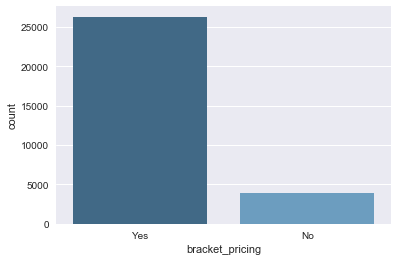

In [11]:
sns.countplot(data=train, x="bracket_pricing", palette="Blues_d")
plt.show()

b. 양적 변수 (예측해야할 종속 변수 cost 포함하여 살펴봄)

In [12]:
train.describe()

,annual_usage,min_order_quantity,quantity,cost
count,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317
std,1590.331872,12.742776,70.761392,28.663200
min,0.000000,0.000000,1.000000,0.503553
25%,0.000000,0.000000,2.000000,3.878190
50%,0.000000,0.000000,10.000000,6.521146
75%,2.000000,0.000000,40.000000,13.431781
max,150000.000000,535.000000,2500.000000,1000.000000


In [13]:
quan_col = ["cost", "annual_usage", "min_order_quantity", "quantity"]
train_quan = train[quan_col]
train_quan.head()

,cost,annual_usage,min_order_quantity,quantity
0,21.905933,0,0,1
1,12.341214,0,0,2
2,6.601826,0,0,5
3,4.687770,0,0,10
4,3.541561,0,0,25


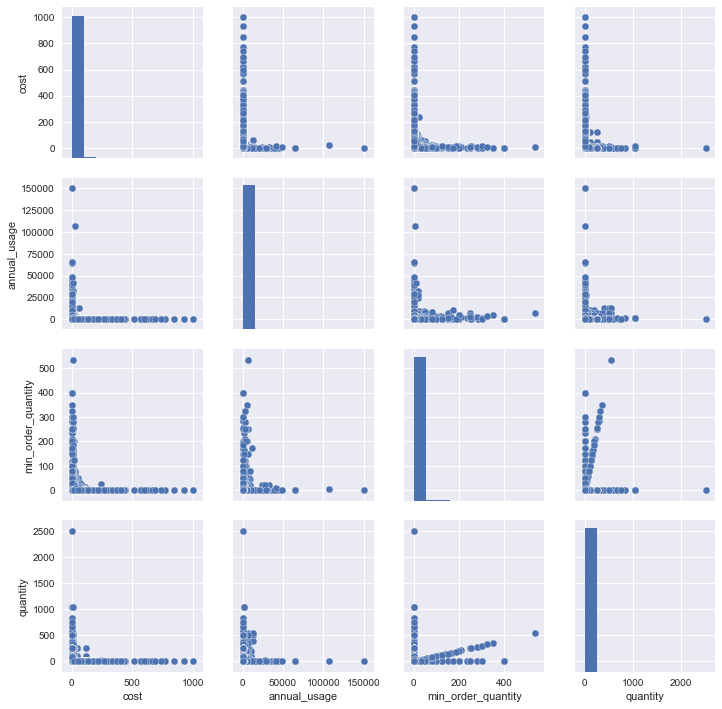

In [14]:
# cost를 비롯한 변수 간의 분포 시각화 
sns.pairplot(train_quan)

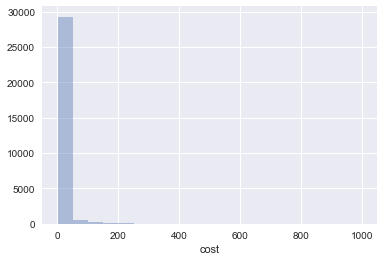

In [15]:
sns.distplot(train['cost'],bins=20, kde=False)
plt.show()

- 대부분의 cost는 낮은 값(15$ 이하)에 몰려있다.

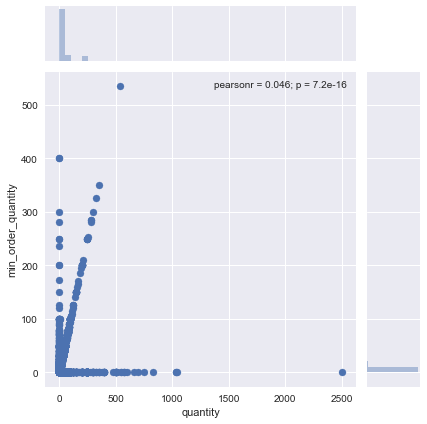

In [16]:
sns.jointplot(x="quantity", y="min_order_quantity", data=train)

- min_order_quantity가 커지면 quantity가 커져야 하나, 그렇지 않은 경우도 있다. 
  견적은 2가지로 매겨진다. (bracket & non-bracket)
  - Bracket: 구매양에 따라 여러 단계로 견적.  
  - Non-bracket: 최소 주문량이 있다. 각 견적은 해당 연도의 소모량에 따른 예상 구매량에 따라 작성됨. 
- Non-bracket의 경우라면 구매량은 최소 주문량 이상이어야 한다.

min_order_quantity 보다 작은 quantity는 min_order_quantity와 같도록 변경해준다.

In [17]:
train['rev_qty'] = pd.Series()
train['rev_qty'] = [train['min_order_quantity'][i] if train['quantity'][i] < train['min_order_quantity'][i] else train['quantity'][i] for i in range(len(train))]

In [20]:
train.shape

(30213, 9)

In [21]:
test['rev_qty'] = pd.Series()
test['rev_qty'] = [test['min_order_quantity'][i] if test['quantity'][i] < test['min_order_quantity'][i] else test['quantity'][i] for i in range(len(test))]

In [22]:
test.shape

(30235, 9)

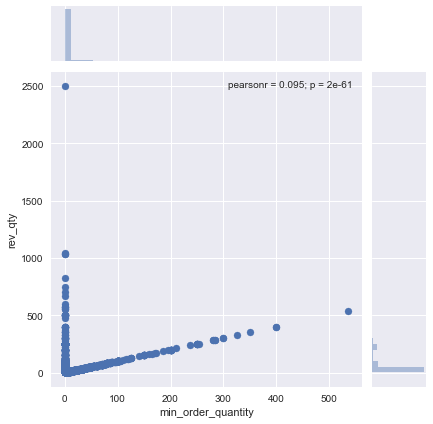

In [23]:
sns.jointplot(x="min_order_quantity", y="rev_qty", data=train)

In [28]:
# quantity, min_order_quantity 제거
train_rev = train.drop(['quantity', 'min_order_quantity'], axis = 1)

In [30]:
test_rev = test.drop(['quantity', 'min_order_quantity'], axis = 1)

c. date 정보

하루 단위로 특징을 잡기에는 범위가 너무 넓다. -> 연, 월로만 본다면?

In [33]:
# quote_date feature를 각각 year, month, day 정보로 분리하고, quote_date는 drop
train_rev['year'] = train_rev.quote_date.dt.year
train_rev['month'] = train_rev.quote_date.dt.month
train_rev['day'] = train_rev.quote_date.dt.day

In [34]:
test_rev['year'] = test_rev.quote_date.dt.year
test_rev['month'] = test_rev.quote_date.dt.month
test_rev['day'] = test_rev.quote_date.dt.day

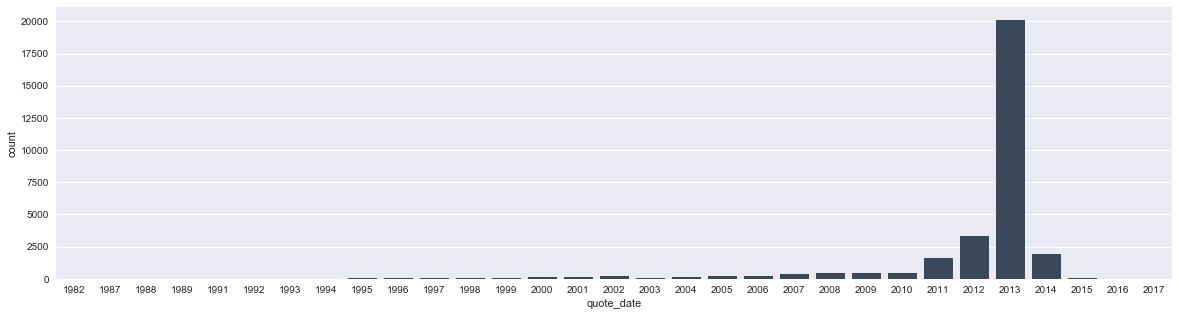

In [35]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e", data=train_rev, x="year", ax=ax)
ax.set(xlabel='quote_date')

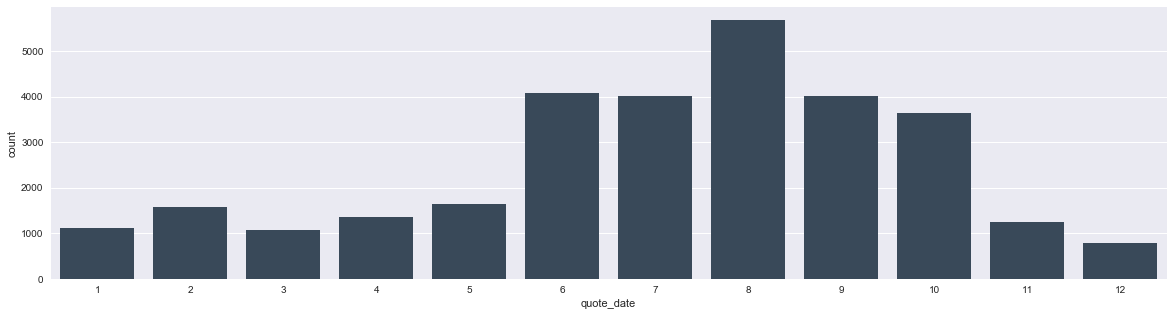

In [36]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e", data=train_rev, x="month", ax=ax)
ax.set(xlabel='quote_date')

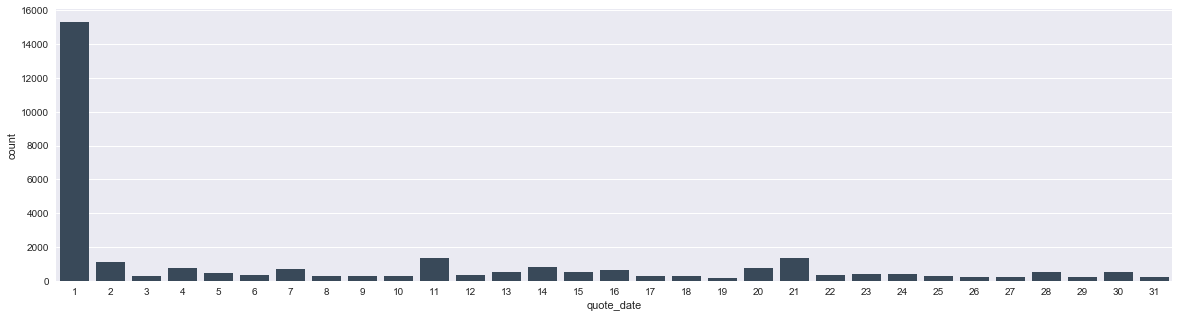

In [37]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.countplot(color="#34495e", data=train_rev, x="day", ax=ax)
ax.set(xlabel='quote_date')
# 대부분의 data가 1일에 치중 -> var. 낮다. 통계적으로 의미??

In [39]:
train_rev = train_rev.drop(['day'], axis = 1)
test_rev = test_rev.drop(['day'], axis = 1)

(가정) 업체와 거래 자주 하였다면, 견적가가 상대적으로 낮을 수 있다.

In [43]:
freq_supp = train_rev.groupby('supplier')['quote_date'].nunique()
freq_supp = freq_supp.reset_index()
freq_supp.columns = ['supplier', 'freq_supp']

train_rev = pd.merge(train_rev, freq_supp, on = 'supplier', how = 'left')
test_rev = pd.merge(test_rev, freq_supp, on = 'supplier', how = 'left')
train_rev = train_rev.drop(['quote_date'], axis = 1)
test_rev = test_rev.drop(['quote_date'], axis = 1)

(가정) TA 별로 공급하는 업체가 많다면, 경쟁입찰 가능하여 견적가가 낮을 것이다.

In [53]:
len(train_rev.tube_assembly_id.value_counts()) # TA 종류 8855 가지

8855

In [54]:
b = train_rev.groupby(['tube_assembly_id', 'supplier'])
len(b.size())
# TA, supplier 별 8908 가지 조합. -> 대부분의 TA는 특정 업체에서 공급한다 (경쟁입찰 비중 매우 낮음)

pickle로 train_rev 저장

In [56]:
pd.to_pickle(train_rev, 'train_rev')
pd.to_pickle(test_rev, 'test_rev')

#### (2) tube_data

- end_a, end_x와 같은 category 변수를 dummy화 시키고, PCA로 차원 축소하였으나 해석이 쉽지 않았음  
  따라서, end_a, end_x의 form_id 대신 forming 여부로 대체

In [59]:
tube_data = pd.merge(tube_data, tube_end, left_on='end_a', right_on='end_form_id')
tube_data = pd.merge(tube_data, tube_end, left_on='end_x', right_on='end_form_id')
tube_data['forming_x'].rename('end_a_forming')
tube_data['forming_y'].rename('end_x_forming')
tube_data = tube_data.drop(['end_a', 'end_x', 'end_form_id_x', 'end_form_id_y'], axis=1)

In [62]:
info(tube_data)

* shape of dataset
(19587, 16)
------------------------------------------
* columns:
Index(['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length',
       'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'num_boss', 'num_bracket', 'other', 'forming_x',
       'forming_y'],
      dtype='object')
------------------------------------------
* brief information of dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19587 entries, 0 to 19586
Data columns (total 16 columns):
tube_assembly_id    19587 non-null object
material_id         19322 non-null object
diameter            19587 non-null float64
wall                19587 non-null float64
length              19587 non-null float64
num_bends           19587 non-null int64
bend_radius         19587 non-null float64
end_a_1x            19587 non-null object
end_a_2x            19587 non-null object
end_x_1x            19587 non-null object
end_x_2x            19587 non-null object
num_boss  

In [63]:
tube_data.describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,19587.000000,19587.000000,19587.000000,19587.000000,19587.000000,19587.000000,19587.000000,19587.000000
mean,22.318861,1.557433,100.502306,3.808853,45.518185,0.040333,0.004646,0.019707
std,23.783537,0.697500,71.032694,2.259694,145.931433,0.252844,0.088262,0.192581
min,4.760000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


length 0, bend_radius 9999 는 이상치로 보임. -> 전처리 필요!

In [64]:
tube_col = ['material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x']
for i in tube_col:
    print('-'*40)
    print(tube_data[i].describe())
    print(tube_data[i].unique())

----------------------------------------
count       19322
unique         19
top       SP-0029
freq        10667
Name: material_id, dtype: object
['SP-0035' 'SP-0029' 'SP-0028' 'SP-0037' 'SP-0046' 'SP-0019' 'SP-0039' nan
 'SP-0044' 'SP-0048' 'SP-0038' 'SP-0033' 'SP-0034' 'SP-0032' 'SP-0031'
 'SP-0036' 'SP-0030' 'SP-0041' 'SP-0008' 'SP-0045']
----------------------------------------
count     19587
unique        2
top           N
freq      18682
Name: end_a_1x, dtype: object
['N' 'Y']
----------------------------------------
count     19587
unique        2
top           N
freq      16798
Name: end_a_2x, dtype: object
['N' 'Y']
----------------------------------------
count     19587
unique        2
top           N
freq      18909
Name: end_x_1x, dtype: object
['N' 'Y']
----------------------------------------
count     19587
unique        2
top           N
freq      17208
Name: end_x_2x, dtype: object
['N' 'Y']


In [65]:
tube_data.isnull().sum()
# material_id에 결측값이 존재 -> 후에 전처리 필요!

tube_assembly_id      0
material_id         265
diameter              0
wall                  0
length                0
num_bends             0
bend_radius           0
end_a_1x              0
end_a_2x              0
end_x_1x              0
end_x_2x              0
num_boss              0
num_bracket           0
other                 0
forming_x             0
forming_y             0
dtype: int64

In [66]:
pd.to_pickle(tube_data, 'tube_data')

#### (4) BOM data
tube assembly를 이루는 componenet의 id와 개수를 알려줌. (comp.는 최대 8가지)

In [67]:
bill_of_materials_data.tail()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
21193,TA-21195,C-1373,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21194,TA-21196,C-1364,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21195,TA-21197,C-1733,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21196,TA-21198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21197,TA-21199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
comp.tail()

,component_id,name,component_type_id
2043,C-2043,FLANGE,CP-004
2044,C-2044,ADAPTER-INLET,CP-006
2045,C-2045,ADAPTER-INLET,OTHER
2046,C-2046,SLEEVE,OTHER
2047,C-2047,FLANGE,OTHER


component의 weight 정보 활용

In [69]:
comp_total = pd.concat([comp_adpt, comp_boss, comp_float, comp_hfl, comp_nut, comp_other, comp_sleeve, comp_straight, comp_tee, comp_threaded])
comp = pd.merge(left = comp, right = comp_total, on = 'component_id', how = 'left')

comp_weight = comp.drop(['name', 'component_type_id_x', 'adaptor_angle', 'base_diameter', 'base_type', 'blind_hole', 'bolt_pattern_long',
       'bolt_pattern_wide', 'component_type_id_y', 'connection_type_id',
       'connection_type_id_1', 'connection_type_id_2', 'connection_type_id_3',
       'connection_type_id_4', 'corresponding_shell', 'coupling_class',
       'diameter', 'drop_length', 'end_form_id_1', 'end_form_id_2',
       'end_form_id_3', 'end_form_id_4', 'extension_length', 'groove',
       'head_diameter', 'height_over_tube', 'hex_nut_size', 'hex_size',
       'hose_diameter', 'intended_nut_pitch', 'intended_nut_thread', 'length',
       'length_1', 'length_2', 'length_3', 'length_4', 'material',
       'mj_class_code', 'mj_plug_class_code', 'nominal_size_1',
       'nominal_size_2', 'nominal_size_3', 'nominal_size_4', 'orientation',
       'outside_shape', 'overall_length', 'part_name', 'plating', 'seat_angle',
       'shoulder_diameter', 'thickness', 'thread_pitch', 'thread_pitch_1',
       'thread_pitch_2', 'thread_pitch_3', 'thread_pitch_4', 'thread_size',
       'thread_size_1', 'thread_size_2', 'thread_size_3', 'thread_size_4',
       'type', 'unique_feature'], axis = 1)

bom_weight = pd.merge(left = bill_of_materials_data, right = comp_weight, left_on = 'component_id_1', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight1 = lambda x: bom_weight['weight'] * bom_weight['quantity_1'])
bom_weight = bom_weight.drop(['component_id', 'component_id_1', 'quantity_1', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_2', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight2 = lambda x: bom_weight['weight'] * bom_weight['quantity_2'])
bom_weight = bom_weight.drop(['component_id', 'component_id_2', 'quantity_2', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_3', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight3 = lambda x: bom_weight['weight'] * bom_weight['quantity_3'])
bom_weight = bom_weight.drop(['component_id', 'component_id_3', 'quantity_3', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_4', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight4 = lambda x: bom_weight['weight'] * bom_weight['quantity_4'])
bom_weight = bom_weight.drop(['component_id', 'component_id_4', 'quantity_4', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_5', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight5 = lambda x: bom_weight['weight'] * bom_weight['quantity_5'])
bom_weight = bom_weight.drop(['component_id', 'component_id_5', 'quantity_5', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_6', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight6 = lambda x: bom_weight['weight'] * bom_weight['quantity_6'])
bom_weight = bom_weight.drop(['component_id', 'component_id_6', 'quantity_6', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_7', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight7 = lambda x: bom_weight['weight'] * bom_weight['quantity_7'])
bom_weight = bom_weight.drop(['component_id', 'component_id_7', 'quantity_7', 'weight'], axis=1)
bom_weight = pd.merge(left = bom_weight, right = comp_weight, left_on = 'component_id_8', right_on = 'component_id', how = 'left')
bom_weight = bom_weight.assign(weight8 = lambda x: bom_weight['weight'] * bom_weight['quantity_8'])
bom_weight = bom_weight.drop(['component_id', 'component_id_8', 'quantity_8', 'weight'], axis=1)

bom_weight = bom_weight.fillna(0)
bom_weight = bom_weight.assign(comp_sum_weight = lambda x: bom_weight['weight1'] + bom_weight['weight2']+ bom_weight['weight3']+ bom_weight['weight4']+ bom_weight['weight5']+ bom_weight['weight6']+ bom_weight['weight7']+ bom_weight['weight8'])
bom_weight = bom_weight.drop(['weight1', 'weight2', 'weight3', 'weight4', 'weight5', 'weight6', 'weight7', 'weight8'], axis=1)

In [74]:
pd.to_pickle(bom_weight, 'bom_weight')

#### (4) Specs data

In [75]:
specs_data

,tube_assembly_id,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TA-00006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TA-00007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TA-00008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TA-00009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TA-00010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
specs_data.info() # 모두 catergory 형 변수

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21198 entries, 0 to 21197
Data columns (total 11 columns):
tube_assembly_id    21198 non-null object
spec1               7129 non-null object
spec2               6844 non-null object
spec3               5840 non-null object
spec4               4154 non-null object
spec5               2921 non-null object
spec6               2071 non-null object
spec7               535 non-null object
spec8               106 non-null object
spec9               20 non-null object
spec10              1 non-null object
dtypes: object(11)
memory usage: 1.8+ MB


In [77]:
specs_data.describe()

,tube_assembly_id,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
count,21198,7129,6844,5840,4154,2921,2071,535,106,20,1
unique,21198,45,51,49,38,37,24,13,4,3,1
top,TA-02862,SP-0007,SP-0012,SP-0080,SP-0026,SP-0080,SP-0082,SP-0082,SP-0082,SP-0088,SP-0080
freq,1,3002,1736,1798,1492,1780,1167,322,73,18,1
